# Financial Analysis Project
### Erik Held & Julien Fernandez

This notebook covers our work done for the course Data Analysis in Finance at HEC Paris.

The goal of this project is to create a trading strategy based on financial and markets data. A successful strategy will have a high Sharpe ratio and low correlation to the general market. 

This project was carried out in multiple steps which will all be covered in separate sections. Firstly the provided data was cleaned to permit easier processing. Thereafter a backtesting environment was created to allow for testing of strategies and thereafter validated. A trading strategy was created and optimised on historical data before lastly being validated on an out-of-sample test set.

Testing of the final investment strategy proved that it is not a strategy for the faint of heart but one which could deliver outsized returns with a bit of luck.

### Sections

- [Data](##Data)

- [Backtesting Environment](#Backtesting-environment)

- [Our Cluster Momentum Strategy](##Our-Cluster-Momentum-Strategy)

- [Parameter Optimisation](##Parameter-optimisation)

- [Strategy Validation](##validation)

- [Conclusion](##conclusion)

- [Future Work](##future-work)

## Data
The provided is data is cleaned and reformatted to facilitate further use by a cleaning function. 

This function can be found in *datacleaner.py*.

It also enabled creation of a train and test set via a *max_time* argument which exlucdes observations later than the specified date.

Below we create a training set including data up to 2017.

In [1]:
from datacleaner import DataCreator
DataCreator(max_time='2017')

## Backtesting Environment
A complete backtesting environment which allows for easy testing of different strategies. This can be found in *backtesting.py*. The environment is modular and works by feeding price and financial data to user-defined strategies. Starting from the beginning of the dataset, the environment gives the strategy a variable amount of historical price and financial data depending on user preference. A strategy is then required to return a series of allocations based on this data. From these series, the environment will calculate the returns of the strategy.

The adjustable parameters for testing are:
- n_prices : how many months of price data to take into account
- n_ratios : how many months of financial data to take into account
- frequency : how often we want to trade


The environment also allows for analysis of the strategy returns and can generate multiple plots and metrics for any given strategy, also comparing them to a market benchmark, which will be illustrated below.

To ensure validity of further results we want to ensure that our backtesting environment is working as intended. This is done by comparing backtest returns from a mock strategy which invests in entire market to a simple mean of the returns from the data. If the backtests results are (roughly) the same as the mean it indicates that the backtest module is working as intended.

100%|██████████| 323/323 [00:01<00:00, 188.51it/s]


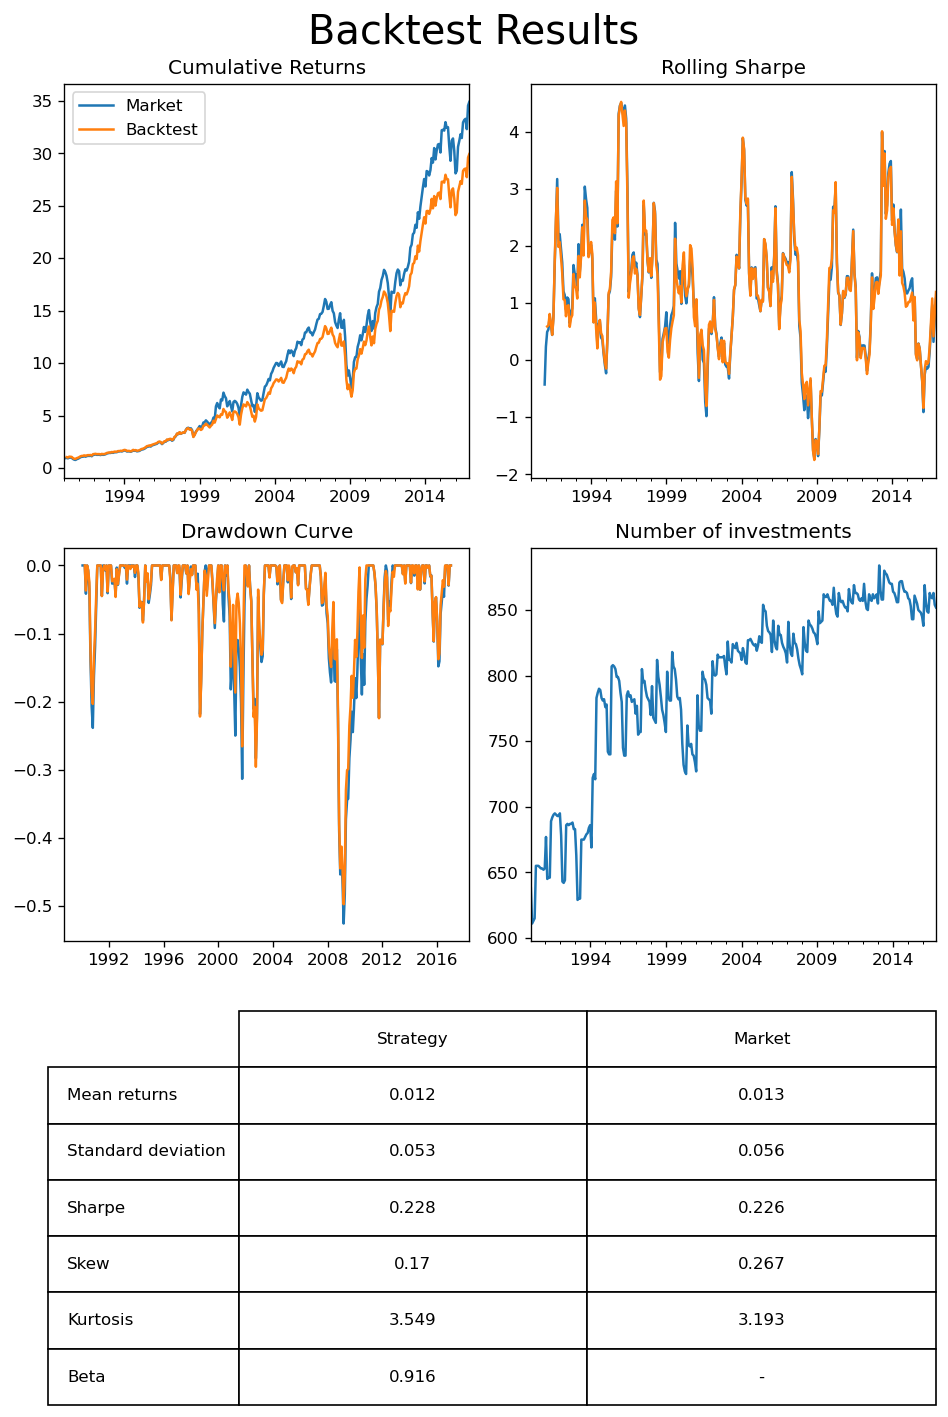

In [2]:
import pandas as pd
from backtest import BackTester

def entire_market(prices, ratios):
    """
    simply strategy to buy an equal amount 
    of all available stocks at any given time
    """
    all_stocks = prices['permno'].unique()
    return pd.Series({s:1/len(all_stocks) for s in all_stocks})

# initialise backtest object
backtester = BackTester()

# run backtest with entire_market strategy
backtester.rolling_test(
    strategy=entire_market,
    n_prices=1,
    n_ratios=1, 
    frequency=1
)

# analyse backtest results
metrics = backtester.analyse()

The backtest of the entire market strategy performs slightly worse than the mean of the returns. 

This is probably due to some data points getting taken out from the backtest as data points are missing. However, the cumulative returns are very similar and the backtesting class seems to be working as intended.

## Our Cluster Momentum Strategy

With a working backtesting system in place we created an investment strategy. The strategy combines data science and finance and consists of multiple steps which are executed as follows:

1. For any given point in time the strategy receives $n$ months of price and data and one month of financial data.
2. Financial data is standardised (0 mean, 1 variance) and passed through principal component analysis to reduce it's dimensionality, preserving $v$ variance.
3. Reduced financial data is used to classify the different stocks into $k$ different clusters.
4. Stocks are ordered by their total return over the $n$ months.
5. The stock with the highest returns from each individual cluster is placed into a portfolio and the Sharpe ratio of this portfolio over the $n$ months is calculated.
6. If it increases the Sharpe ratio, another stock from each clusted is added to the portfolio. This is done iteratively until it does not improve the Sharpe ratio.
7. Once the best amount of stocks is found, all stocks are given an equal proportion of the portfolio. For the time being, the strategy only takes long positions.

Given the structure of the strategy as well as the backtesting environment, there are a few variable parameters:

- $n$ : the number of months of price data to include, this namely affects the calculation of return and Sharpe ratios, this is passed to the backtesting environment
- $f$ : the frequency of trading, this is passed to the backtesting environment.
- $v$ : the amount of variance which is preserved when performing principal component analysis.
- $k$ : the number of clusters which are created.

Below these parameters are chosen arbitrarily in a first attempt, however, we will later try to optimise them to improve returns.

100%|██████████| 321/321 [00:14<00:00, 21.80it/s]


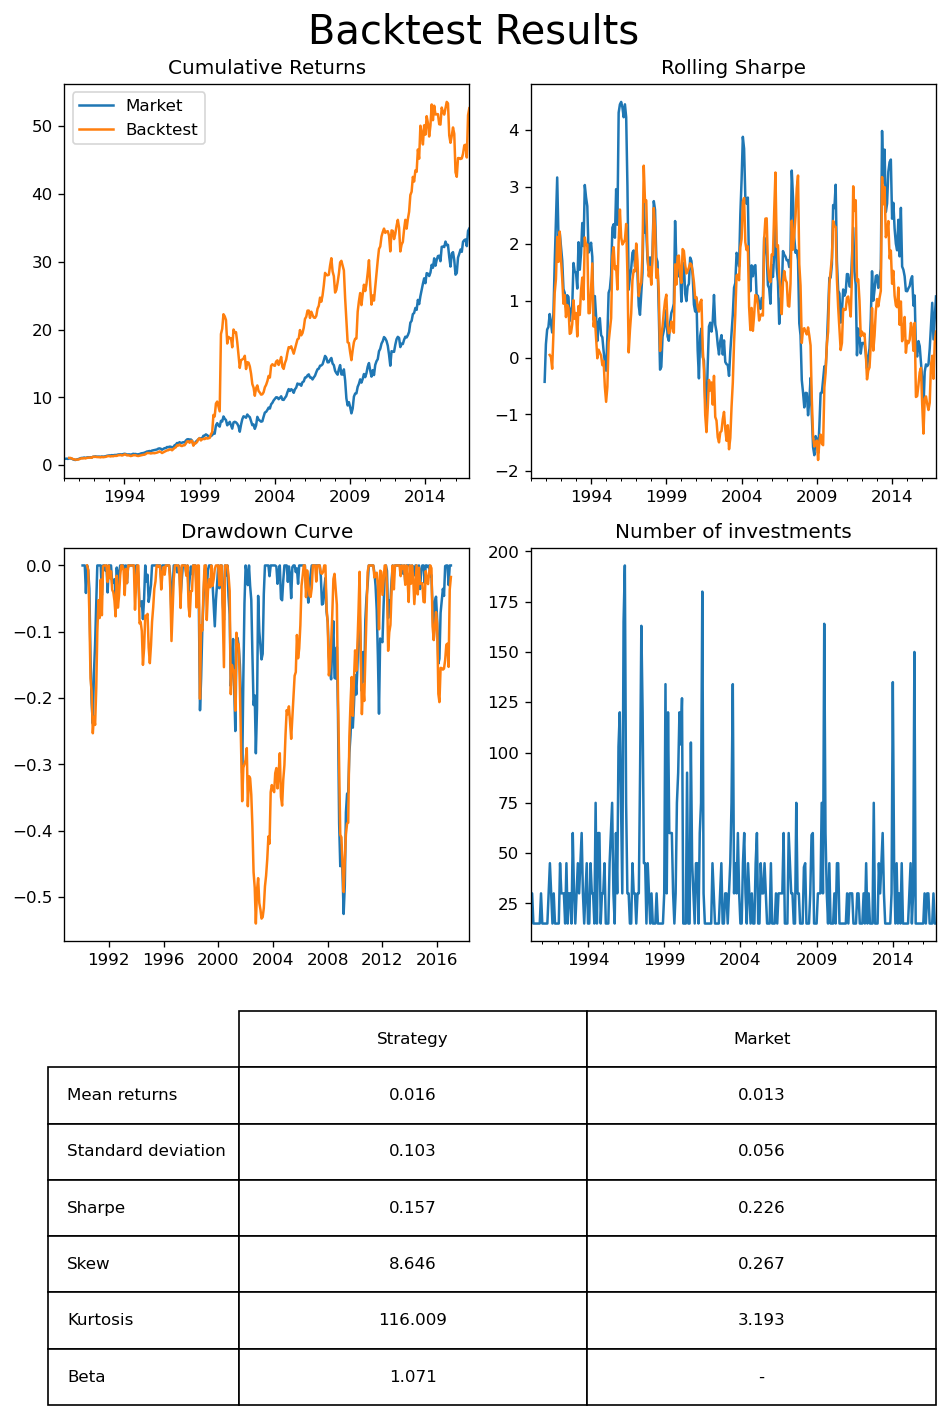

In [4]:
from strategy import ClusterMomentum

initial_params = {
    'n' : 3, 
    'f' : 1,
    'v' : 0.9,
    'k' : 15}

# create new backtester object
backtester = BackTester()

# create strategy object
clustermomentum = ClusterMomentum(
    n_clusters=initial_params['k'],
    variance=initial_params['v']
)

# run backtest
backtester.rolling_test(
    strategy=clustermomentum.strategy,
    n_prices=initial_params['n'],
    n_ratios=1,
    frequency=initial_params['f']
)

# analyse backtest results
metrics = backtester.analyse()

The first attempt of the strategy proved very volatile. While it in total delivered greater cumulative returns than the market. It does this at the cost of a significant increase in the standard deviation, which leads to it having a smaller Sharpe ratio than the general market. This is also emphasised by the immense kurtosis of the returns, which is significantly larger than that of the market. The frequent large losses are also illustrated in the drawdown curve.

## Parameter Optimisation
To improve the results of our investment strategy we want to find better parameters for the strategy and the backtest. To do this we will use Optuna, an automatic hyperparameter optimisation framework.

We will first create an objective function, in our case we will make this a backtest of the strategy for data up to 2017 and return the Sharpe ratio of this backtest. Within this objective function, we also define the variable parameters which Optuna will try to optimise using Bayesian optimisation. Optuna will then iteratively run trials and try to improve the results based on the knowlegde gained from previous trials. 

With some luck, this should give us a better Sharpe ratio than the one achieved above.

In [5]:
# this has been commented out and parameters
# are saved below for convenience 

'''import optuna

def objective(trial):
    # the search space for hyperparameters
    v = trial.suggest_float('v', 0, 1)
    k = trial.suggest_int('k', 1, 50)
    n = trial.suggest_int('n', 2, 12)
    f = trial.suggest_int('f', 1, 12)

    # initialise strategy which suggested parameters
    clustermomentum = ClusterMomentum(
        n_clusters=k,
        variance=v
    )

    # run backtest with suggested parameters
    backtester.rolling_test(
        strategy=clustermomentum.strategy,
        n_prices=n,
        n_ratios=1,
        frequency=f,
        disable_tqdm=True
    )
    
    # return Sharpe ratio of backtest
    return backtester._get_metrics(backtester.results)['Sharpe']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, n_jobs=-1, show_progress_bar=True)'''

best_params = {'v': 0.11384586984345649, 'k': 25, 'n': 9, 'f': 7}

100%|██████████| 45/45 [00:03<00:00, 11.70it/s]


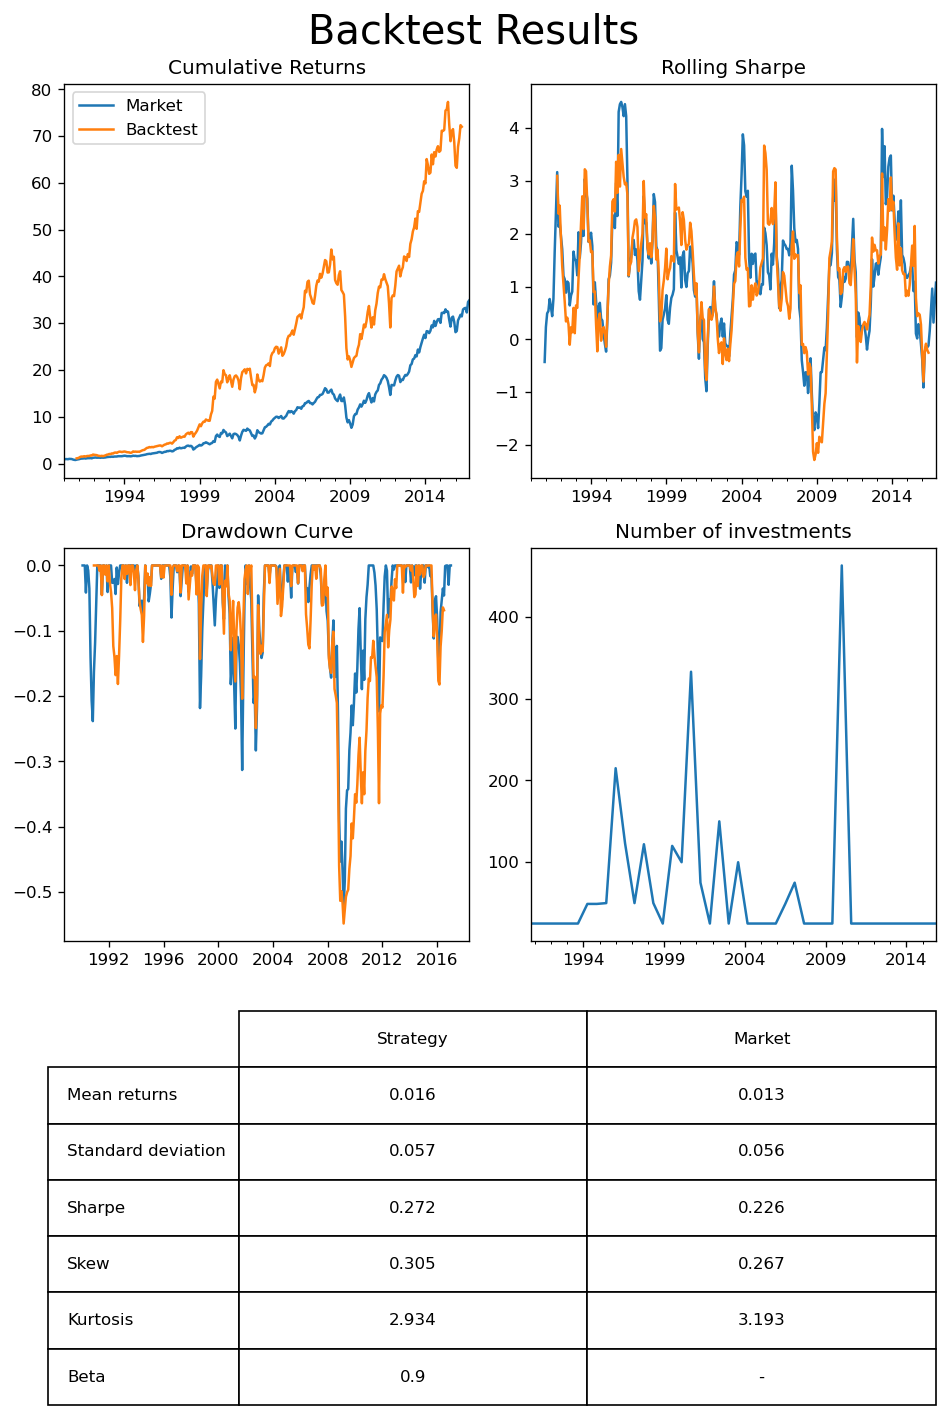

In [6]:
# initialise strategy with parameters
clustermomentum = ClusterMomentum(
    n_clusters=best_params['k'],
    variance=best_params['v']
)

# run backtest with suggested parameters
backtester.rolling_test(
    strategy=clustermomentum.strategy,
    n_prices=best_params['n'],
    n_ratios=1,
    frequency=best_params['f'],)

backtester.analyse()

The new parameters are somewhat surprising but deliver superior results. 

- $n = 9$, using 9 months of data to calculate momentum probably induces more stability in the portfolio as stocks will need to deliver returns and low volatility for a longer period before getting selected for the portfolio.
- $f = 7$, the best result was achieved when trading every 7 months. Given that no trading costs are included in the calculations it is not certain why less frequent trading yields better results. This could be a case of data mining where this number just happened to work given the data without necessarily working in other circumstances.
- $v = 0.11$, only a small amount of the variance is kept when passing the financial ratios through the principal component analysis, this could indicate that most of the data in there does not result in better clusters. Given more time if would be interesting to further analyse the financial data and only pass pertinent data.
- $k = 25$, the model prefers a large amount of clusters, given the small amount of variance which is kept, it is uncertain if the clusters are significantly different. A plausible explanation high number could be that is forces investments in a greater amount of stocks which should better diversify the portfolio.

The updated parameters yield the same mean returns as the arbitrarilty chosen parameters but with a significantly lower standard deviation which makes for a greater Sharpe ratio. It also has significantly higher returns than the market portfolio with only a marginally higher standard deviation. Notably, it has a lower kurtosis than both the original model and the market, which indicates less "fat tails" and large portfolio value movements. Lastly, the Beta to the market has decreased.

## Validation

To validate the strategy improve we will compare it to the market for the entire dataset, which includes data up to the end of 2022.

In [7]:
# create data without max time
DataCreator()

# initialise backtest environment with data
backtester = BackTester()

100%|██████████| 56/56 [00:05<00:00, 10.57it/s]


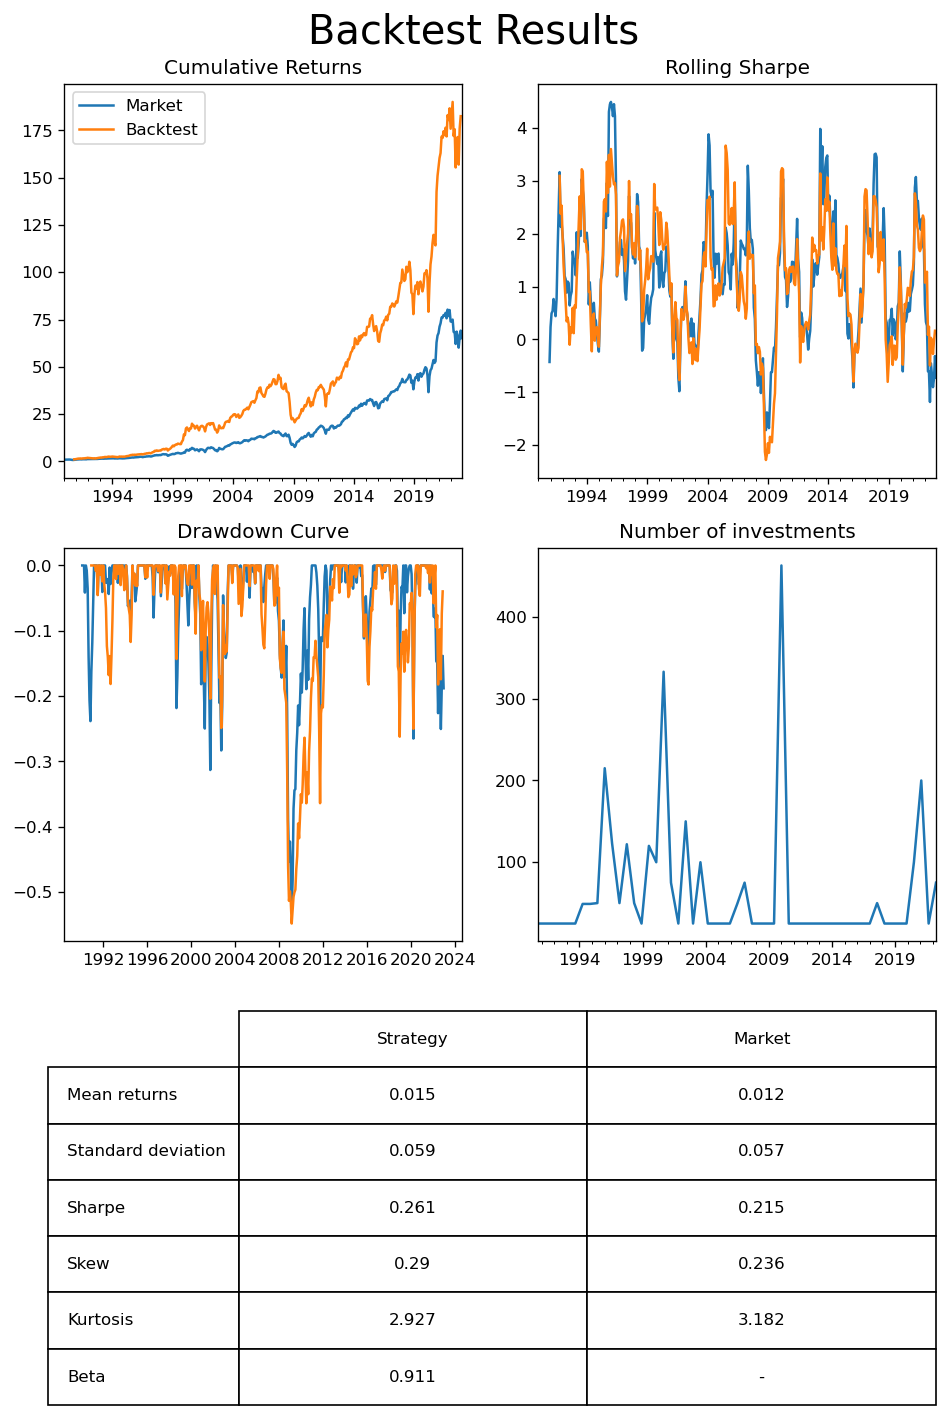

In [8]:
# try with best params from optuna

# initialise strategy with parameters
clustermomentum = ClusterMomentum(
    n_clusters=best_params['k'],
    variance=best_params['v']
)

# run backtest with suggested parameters
backtester.rolling_test(
    strategy=clustermomentum.strategy,
    n_prices=best_params['n'],
    n_ratios=1,
    frequency=best_params['f'],)

backtester.analyse()

As seen in the above graphs, the strategy largely outperforms the market after 2016 in terms of cumulative returns. Despite massive cumulative returns for both the strategy and the market during the validation period (2017-2022), both approaches yielded lower mean returns with a higher standard deviation. However, the difference in performance between our strategy and the market remained similar.

## Conclusion

We created a functional backtesting environment which allowed for easy testing of investment strategies and analysis of their returns. This environment was validated by testing a strategy investing in the entire market which yielded near identical results as the market, this indicates that the environment is working as intended.

With the backtesting environment in hand we created a strategy combining data science and finance based on clustering and momentum. Initial testing showed that this strategy delivered superior returns to the market but at the cost a higher volatility and thus lower Sharpe ratio. 

To improve our strategy we found better values for the variable parameters in the strategy by using an automatic hyperparameter optimisation framework. This greatly improved the results and our strategy now yielded a significantly higher Sharpe ratio than the market. 

In order to validate the improved strategy we ran it on an out-of-sample test set which had previously been excluded. The results were largely consisted with those seen in-sample, indicating stability of the strategy. 

## Future Work

One line of future work is a further exploration of the parameters found during the parameter optimisation. As mentioned, some of these are suprising and could be working thanks to simple dumb luck.

Further analysis of the financial data could also be useful. As previously mentioned, most of the variance within the data is discarded when passed through principal component analysis. An exploration of the financial data and how it correlates with returns could enable a more intelligent use of the financial data. 

Lastly, our strategy largely seems to follow the market trends with drawdowns and peaks at similar moments with a high correlation and rather high Beta. This correlation could potentially be decreased by introducing short positions into the portfolio which is currently long-only.